<a href="https://colab.research.google.com/github/jmb45/GenAI/blob/main/HW2/Copy_of_Image_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Generation with a Diffuser Model**

* We need to install the following libraries:

   1. **diffusers**: This is the core library that contains the Stable **Diffusion Pipeline**.

   2. **transformers**: This provides the **CLIP model**, which acts as the translator between the text prompt and the image generator.

   3. **accelerate**: This helps handle the heavy mathematical lifting on the GPU.
   
   4. Make sure to ask for a GPU to run this norebook:

   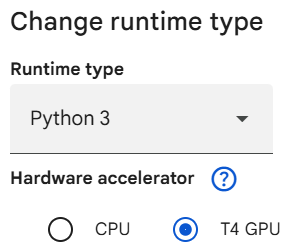



In [ ]:
# the needed libraries
!pip install diffusers transformers accelerate



In [ ]:
import diffusers
import os

# Disable the problematic progress bar widgets
diffusers.logging.disable_progress_bar()
os.environ["TQDM_DISABLE"] = "1"

# **The Running Environment**

1. We first go to the **Hugging Face Model Hub** and download all the AI models such as the VAE, the **CLIP** tokenizer, etc.

2. **CLIP** stands for **Contrastive Language-Image Pre-training**
   * A model developed by OpenAI that acts as a bridge between **words** and **pictures**.
   
   * **CLIP** was trained by looking at 400 million pairs of images and their captions from the internet to learn how they relate.

   * E.g. If you show it a **photo of a dog** and **the text "a photo of a dog,"** it learns to push those together in its **latent space**.

2. We then move the 4GB+ of model weights from the computer's general memory into the Graphics Card's memory.

3. A CPU might take 5 minutes to make one image but aa CUDA-enabled GPU (NVIDIA) can do it in 2 seconds.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# Load the model into memory
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")





# **The Sculptor**

* **Stable Diffusion** creates images by starting with some noise and slowly cleaning it up.

* The **seed** is the number that determines exactly what that static looks like before the AI starts its work. So, if you use Seed 42, the formula always spits out the exact same pattern of noise.


* **num_inference_steps** is the most important parameter here

* It tells the AI how many times to **chip away** at the noise.

    * **1-10 Steps**: You'll see blurry blobs

    * **20-50 Steps**: You'll see sharper details and textures

* **Note**:

  * **CLIP**, the **translator**, uses **Visual Tokens** (14x14 patches).
  * It needs them to **read** an image so it can match it to a caption.
  * **Stable Diffusion**, the **sculptor**, uses a **Latent Space**.


In [ ]:
# Create a generator with a fixed seed
generator = torch.Generator("cuda").manual_seed(1234)

pipe.set_progress_bar_config(disable=True)

prompt = "Batman overlooking a city from a building"
neg_prompt = "dark, tower, building"


image = pipe(
    prompt = prompt,
    negative_prompt = neg_prompt,
    num_inference_steps=50,
    guidance_scale=7.5,
    generator=generator
).images[0]

display(image)

# **Image Diffusion in Steps**

---
1. **Training or the "Learning" process**

 * We teach the AI to be a **restorer**
 * We take a perfectly clear image
 * We intentionally destroy it by **adding layers of random Gaussian noise (epsilon)** until it is unrecognizable:

 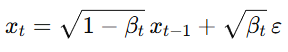

* Where,
  * X_t-1 is the image at the previous step
  * X_t is the image afteradding noise
  * beta_t is how much noise we want to add

 * We show the AI **each noisy image** and **the actual noise** we added.
 * We then ask: **"Can you predict exactly what noise I just added?"**

  * The AI gets better and better at identifying the  **signature** of noise versus the **signature** of a cat

---
**2. Generation or the "Creative" process**

* We start with a **block of pure noise** with a  random seed
* **CLIP** takes the prompt and tells the image **sculptor** what to look for in that noise.

 * The **sculptor** looks at the noise and decides **some of this noise looks like a cat's ear**. It then predicts that noise and subtracts it.

 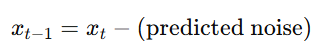

 * This happens 30–50 times, while each step makes the image slightly cleaner until the final image is produced.

 ---


 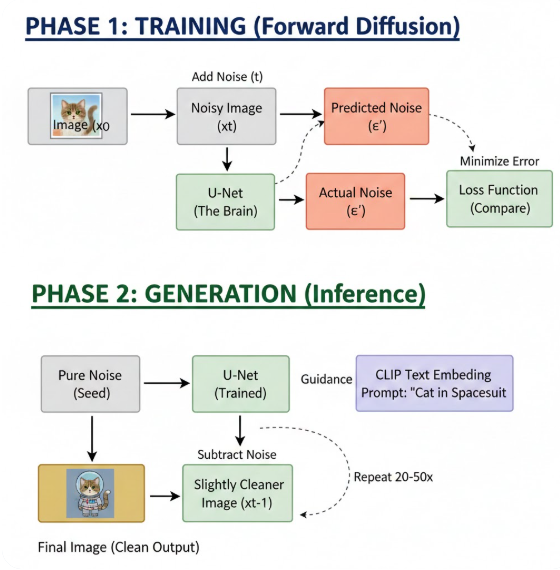



In [ ]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator("cuda").manual_seed(1234)
intermediate_images = []

def latents_callback(pipe, step_index, timestep, callback_kwargs):
    # Capture every 5 iterations
    if (step_index + 1) % 5  == 0:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            # Decode and process latent to PIL
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()
            pil_image = pipe.numpy_to_pil(image)[0]
            intermediate_images.append((step_index + 1, pil_image))

    return callback_kwargs

# Run the generation
final_image = pipe(
    prompt="Batman overlooking a city from a building",
    num_inference_steps=50,
    guidance_scale=7.5,
    generator=generator,

    callback_on_step_end=latents_callback,
    callback_on_step_end_tensor_inputs=['latents']
).images[0]

# Add the final result to our list
intermediate_images.append((50, final_image))

# --- Display in a Matrix ---
cols = 3
rows = (len(intermediate_images) + cols - 1) // cols
# figsize is (width, height) in inches.
# Since we want roughly 1x1 inch images, we scale by the grid size.
plt.figure(figsize=(cols, rows))

for i, (step, img) in enumerate(intermediate_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Step {step}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

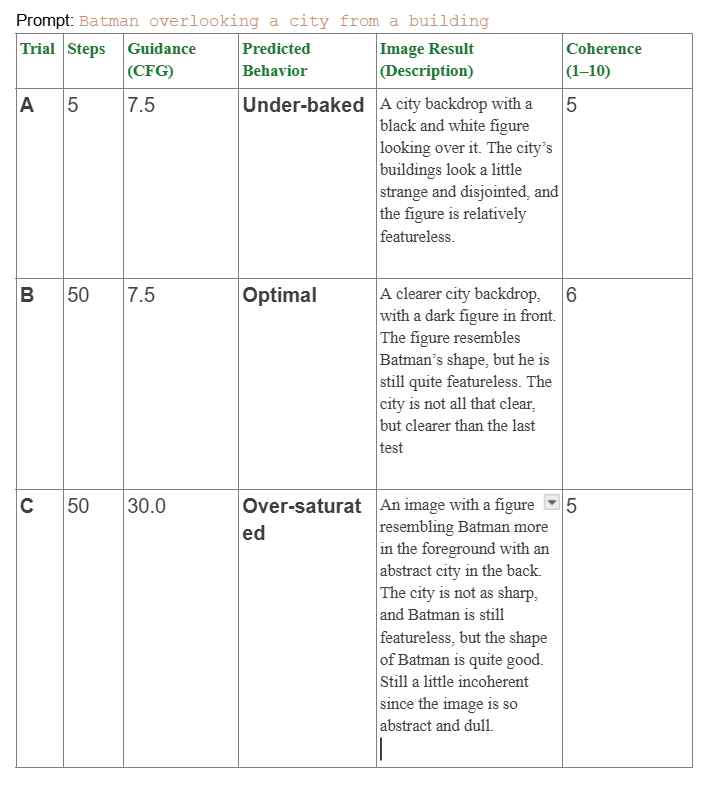


Image A:

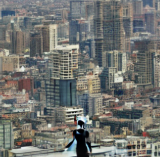

Image B:

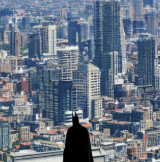

Image C:

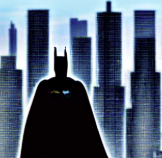

Analysis:

1. Image A results in a more incoherent picture than image B. This is because the AI hasn't had enough time to sharpen the image. This is what the point of steps are. It reduces the amount of noise and makes the image more coherent. Since image A had less steps, the figure looks disjointed, and the buildings are running into each other. Because of this lack of clarity, Image A resulted in a somewhat blurry image due to the reduced steps.

2. The colors in Image C are too dark, and the contrast is too high. This is because we increased the guidance to 30. With 30 guidance, the model hones in on my prompt a little too much. This pushes the math of the model too far, and results in too high of a contrast and an unrealistic image. We can see that trial B had a more realistic looking city. With the high guidance, the model focused in on the city too much and it resulted in a worse looking city. This is why a moderate guidance is best, to allow some room for creativity.

3. Doubling the steps does about double the amount of time it takes for the image to generate. This makes sense, because the model has to do twice the amount of work in order to generate an image corresponding to my prompt. With each step, it sharpens the image a little more in order to denoise the image and move closer to my prompt. So, if there is twice the amount of sharpening, and twice the amount of work, it accordingly takes the model twice the amount of time to generate my image.


EXTRA CREDIT:
1. The results were an image of Batman overlooking the city. However, the image of Batman was much clearer than any of the other trials. He also had more features rather than just being a dark blob. The city is a little bit unclear, which is perhaps understandable since one of my negative prompts was 'building'.
2. A negative prompt can be more powerful than a positive prompt because of how a negative prompt interacts with the latent space. The latent space is so large - by making a longer positive prompt, the model might get confused or lost in it since there is just so much noise. By using a negative prompt, you can tell the model to explicitly avoid certain areas of the space. This will help the model avoid a lot of confusion, because it can look elsewhere in the latent space rather than wasting time looking through things that you don't want.
3. My prompt does not have to do with a hacker terminal, but rather Batman overlooking the city. The model kept to the prompt quite well. I rate it a 7. It sharpened up the image of Batman, defining his features more clearly. It also added a tool belt to him, which is better than having him dressed in entirely black. We can make out his limbs as well rather than him being a humanoid blob. The image looks quite similar to the other ones - that is to say, it is very on theme, and it did arguably better. The only things it messed up on are the clarity of the city and the way Batman's cape looks.



Prompt: "Batman overlooking a city from a building"

Neg Prompt: " dark, tower, building"


Image:
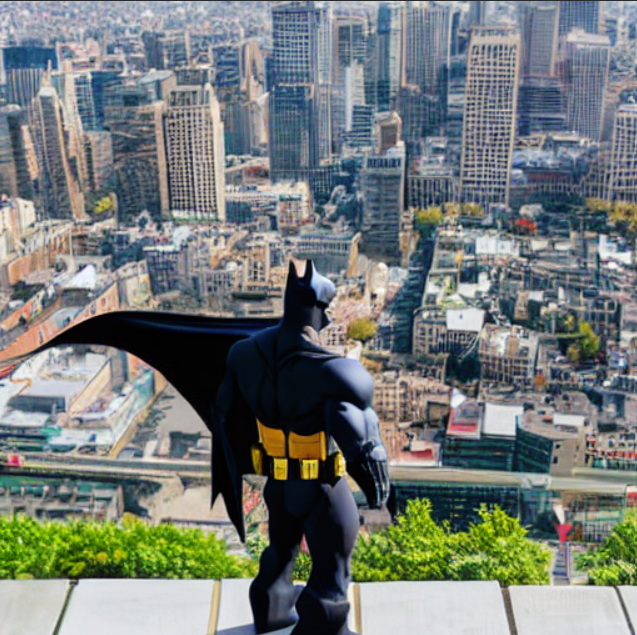